In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


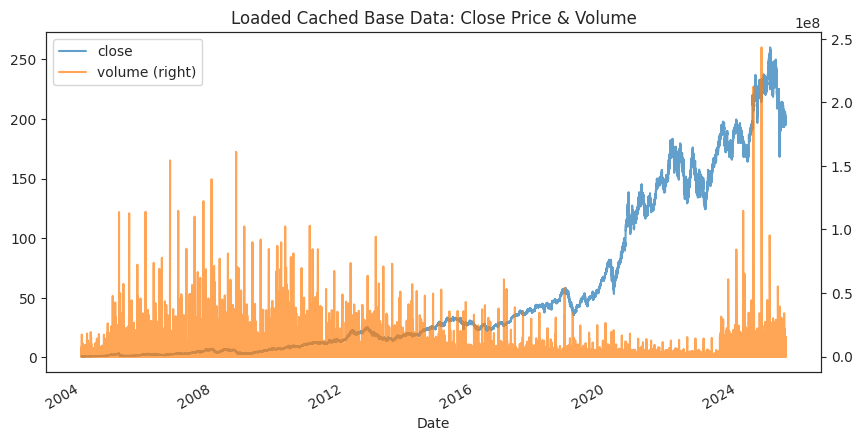

open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 09:00:00     28000.0    0.764857    0.763714  
2004-01-02 09:01:00     28000.0    0.764857    0.763714  
2004-01-02 09:02:00     28000.0    0.764857    0.763714  
2004-01-02 09:03:00     28000.0    0.764857    0.763714  
2004-01-02 09:04:00     28000.0    0.764857    0.763714  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.962600  196.667400  
2025-06-18 20:57:00    460630.0  196.822500  196.527500  
2025-06-18 20:58:00    525245.0  196.817500  196.522500  
2025-06-18 20:59:00   2075503.0  196.387200  196.092800  
2025-06-18 21:00:00  15600625.0  196.687400  196.392600  

[3893400 rows x 7 columns]

In [2]:
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = params.ticker,
        bidasktoclose_pct   = params.bidasktoclose_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
def process_single_day(day_str: str, hyperparams: dict):
    """
    Process and plot a single trading session using a given set of hyperparameters.

    Returns:
      Tuple[pd.DataFrame, Dict] | None
        If a valid backtest runs, returns (df_day, perf_day).
        If no data or no trades, returns None.
    """
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    # Extract that day’s full-minute bars from the master df
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    print("\n Running trading pipeline on selected date …")
    # Call run_trading_pipeline with your per-day slice + EXACTLY the same best_optuna_params
    result = trades.run_trading_pipeline(
                                        df                       = day_df,
                                        col_signal               = 'signal',
                                        col_action               = 'signal_action',
                                        day_to_check             = day_str,
                                        **best_optuna_params            # unpack tuned parameters here
    )
    if result is None:
        print(" no trades found; skipping.")
        return

    # Unpack pipeline output: (df_signals, trades_list, performance_stats)
    df_day, trades_day, perf_day = result

    # Plot the equity & trade markers
    plots.plot_trades(
                    df                 = df_day,
                    col_signal1        = 'signal',
                    col_signal2        = False,
                    col_action         = 'signal_action',
                    trades             = trades_day,
                    buy_threshold      = best_optuna_params['buy_threshold'],
                    performance_stats  = perf_day,
                    start_plot         = params.sess_start # or sess_premark 
    )

    # Print the per-day summary
    print(f"\n* Performance for {day_dt.date()} *")
    for k, v in perf_day.items():
        print(f"  {k}: {v}")

    return df_day, perf_day


In [4]:
def saveDF_checkDAY(df: pd.DataFrame, best_optuna_params: dict):
    """
    Backtest in two modes and optionally save a full‐run CSV of signals,
    using the supplied hyperparameters.

    Modes:
      • Month mode (params.date_to_check = 'YYYY-MM'):
          – process each trading day via process_single_day(..., best_optuna_params)
          – plot monthly aggregate performance
          – return the month’s concatenated DataFrame (empty if none)

      • Full‐run mode (params.createCSVsign == True):
          – run the identical pipeline used by Optuna over all days
            with **best_optuna_params
          – compute & print the full‐period summary
          – plot full‐period performance
          – isolate & compute the test‐period summary
          – plot test‐period performance
          – save the dataframe with the calculated signal
          – return the full‐run DataFrame
    """
    keep_cols = [
        "open","high","low","close",
        "volume","bid","ask",
        "StrategyEarning","EarningDiff",
        "signal","signal_action"
    ]

    # ── Month mode ────────────────────────────────────────────────────
    print(f"\nMonth mode: processing {params.date_to_check}")
    month_days = (
                df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
                  .index.normalize()
                  .unique()
    )

    month_frames, month_stats = [], []
    for day in sorted(month_days):
        # Pass best_optuna_params into process_single_day
        res = process_single_day(day_str = str(day.date()), 
                                 best_optuna_params = best_optuna_params)
        
        if res is None:
            continue
        df_day, stats = res
        month_frames.append(df_day)
        month_stats.append(stats)

    if not month_frames:
        print("No valid days in this month.")
        return pd.DataFrame(columns=keep_cols)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)

    # If we aren’t saving a full-run CSV, bail out
    if not params.createCSVsign:
        return df_month

    # ── Full‐run mode ────────────────────────────────────────────────
    print("\nFull‐run mode")
    print("• Running trading pipeline on full dataset …")
    # Unpack best_optuna_params into run_trading_pipeline exactly as in Optuna
    full_sim_results = trades.run_trading_pipeline(
                                                    df            = df,
                                                    col_signal    = 'signal',
                                                    col_action    = 'signal_action',
                                                    **best_optuna_params
    )

    # 1) Build combined DF & perf list (zeros on no‐trade days)
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_sim_results.values()]

    # 2) Print & plot full‐period performance using df_all
    print("\nFull‐period performance:")
    plots.aggregate_performance(perf_all, df_all)

    # 3) Test‐period slice & plot
    days_all  = df_all.index.normalize().unique()
    cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_sim_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]

    print("\nTest‐period performance:")
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print("\n• Saving signals CSV …")
    df_all.to_csv(params.sign_csv)
    print(f"Saved to {params.sign_csv}")

    return df_all


best_optuna_value: 0.7703388888888889
best_optuna_params: {'min_prof_thr': 0.018009136698289324, 'max_down_prop': 0.3234743841469339, 'gain_tightening_factor': 2.7049355613307466, 'merging_retracement_thr': 0.14799998461205305, 'merging_time_gap_thr': 1.70775080155516, 'pre_entry_decay': 0.08467635003841605, 'short_penal_decay': 2.652105341719827, 'trailing_stop_pct': 0.020197257566260847, 'buy_threshold': 0.320812477216252, 'top_percentile': 1.2775764906477793}

Month mode: processing 2009-06

=== Processing trading day 2009-06-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


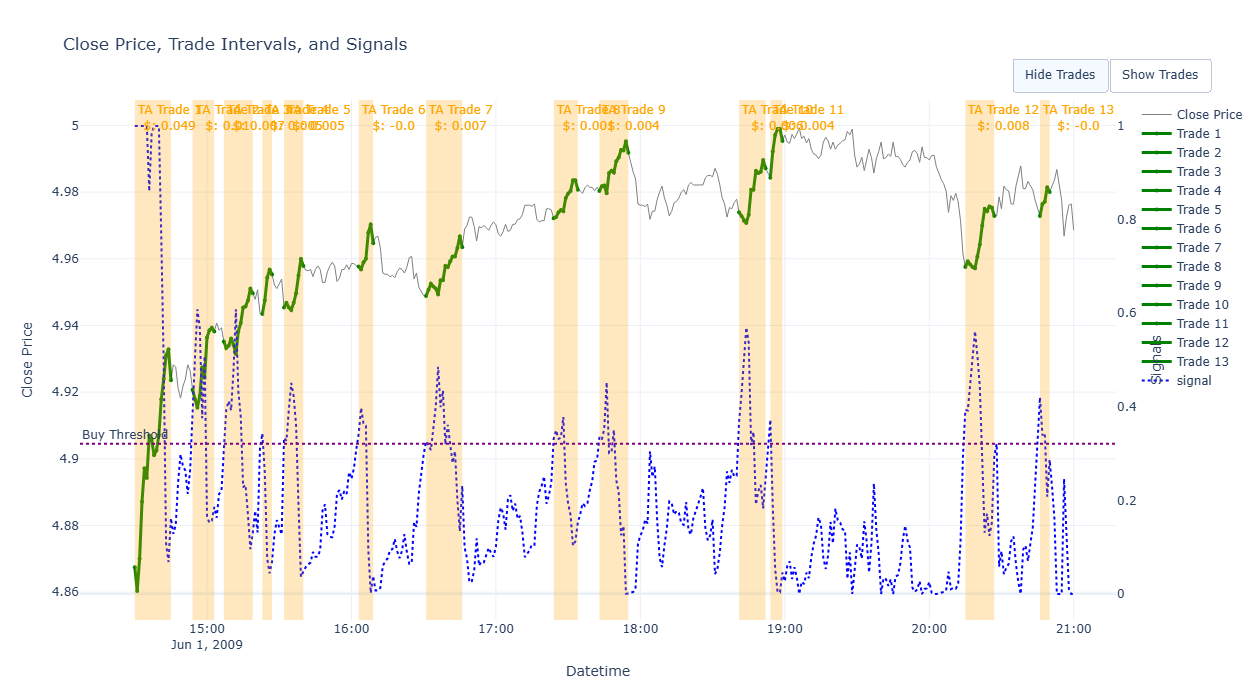


* Performance for 2009-06-01 *
  Buy & Hold Return ($): 0.094
  Strategy Return ($): 0.104
  Trades Returns ($): [0.049, 0.01, 0.007, 0.005, 0.005, -0.0, 0.007, 0.001, 0.004, 0.006, 0.004, 0.008, -0.0]

=== Processing trading day 2009-06-02 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


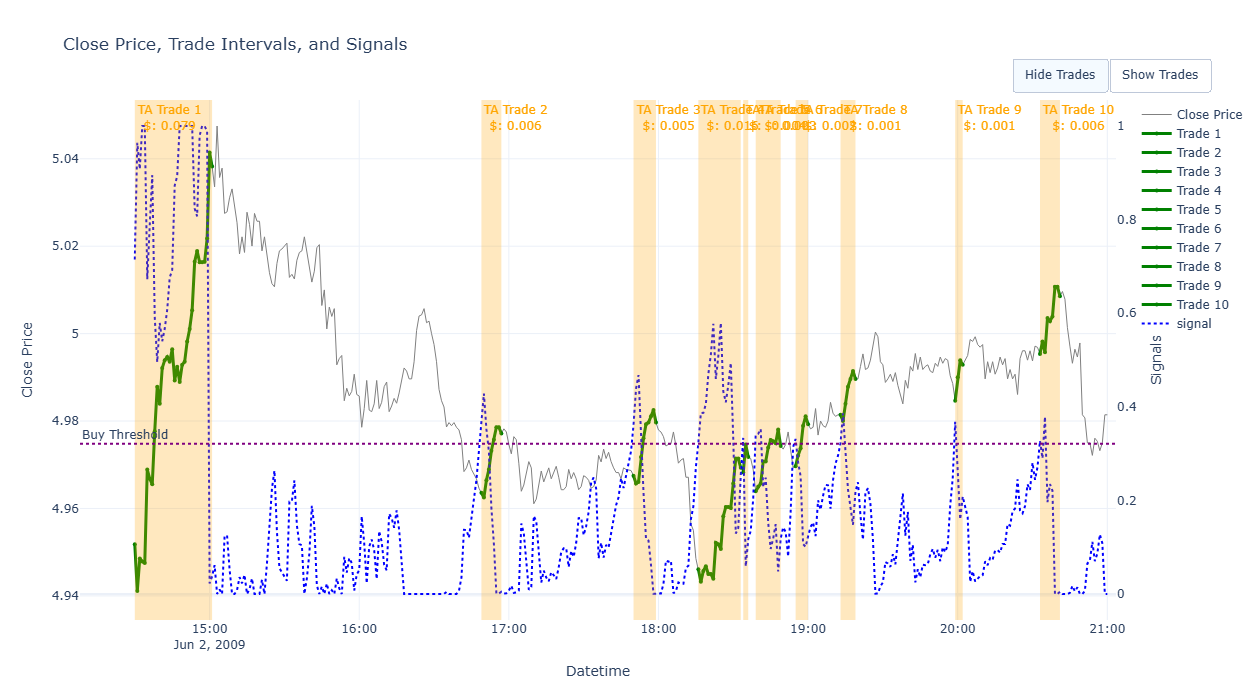


* Performance for 2009-06-02 *
  Buy & Hold Return ($): 0.022
  Strategy Return ($): 0.114
  Trades Returns ($): [0.079, 0.006, 0.005, 0.016, -0.004, 0.003, 0.002, 0.001, 0.001, 0.006]

=== Processing trading day 2009-06-03 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


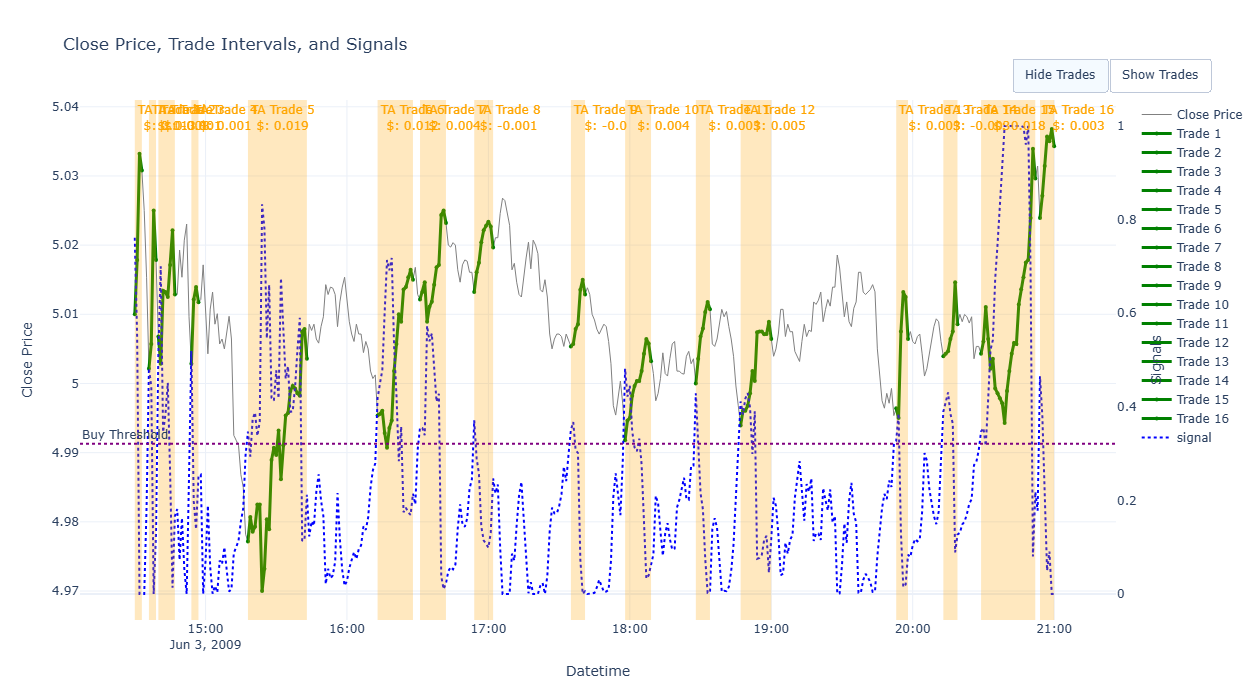


* Performance for 2009-06-03 *
  Buy & Hold Return ($): 0.017
  Strategy Return ($): 0.087
  Trades Returns ($): [0.013, 0.008, -0.001, 0.001, 0.019, 0.012, 0.004, -0.001, -0.0, 0.004, 0.003, 0.005, 0.003, -0.003, 0.018, 0.003]

=== Processing trading day 2009-06-04 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


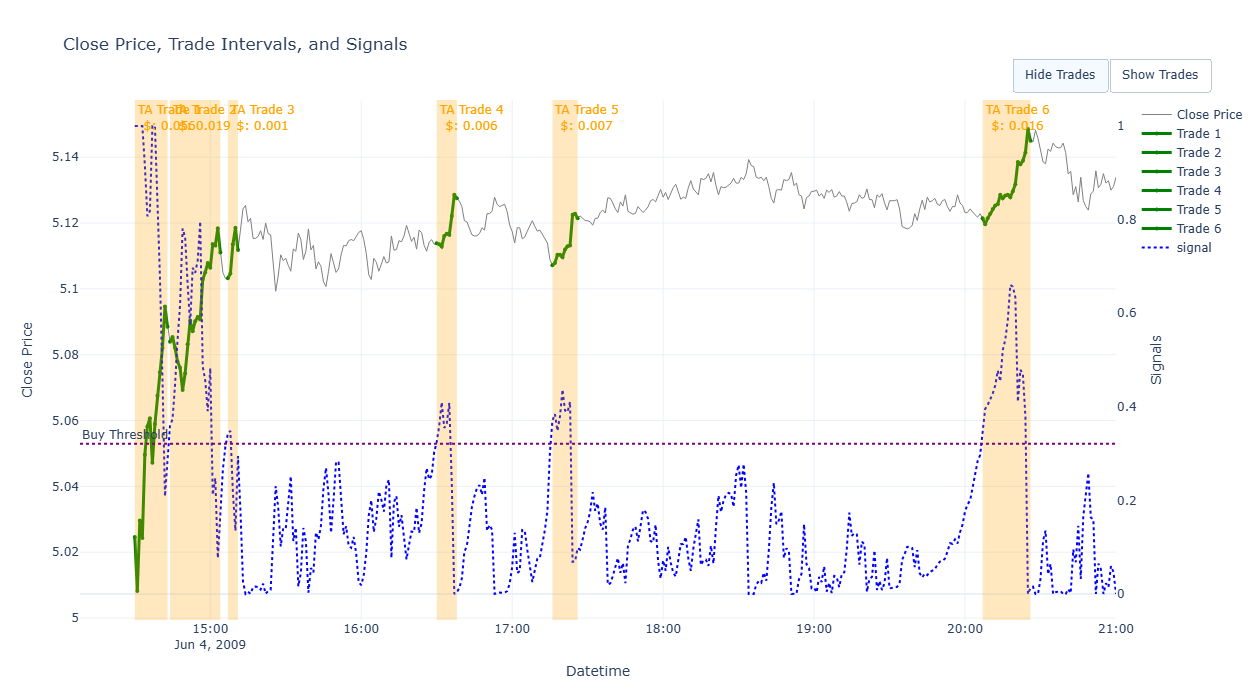


* Performance for 2009-06-04 *
  Buy & Hold Return ($): 0.102
  Strategy Return ($): 0.105
  Trades Returns ($): [0.056, 0.019, 0.001, 0.006, 0.007, 0.016]

=== Processing trading day 2009-06-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


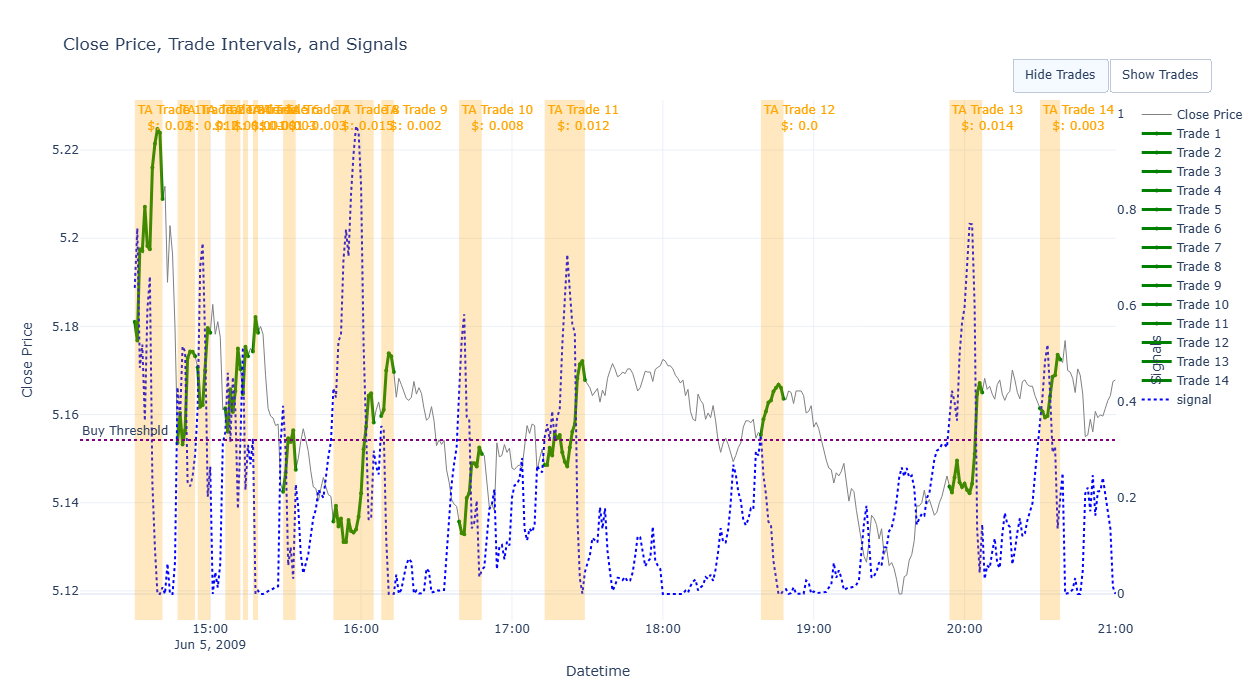


* Performance for 2009-06-05 *
  Buy & Hold Return ($): -0.021
  Strategy Return ($): 0.081
  Trades Returns ($): [0.02, 0.012, 0.0, 0.001, 0.001, -0.003, -0.003, 0.015, 0.002, 0.008, 0.012, 0.0, 0.014, 0.003]

=== Processing trading day 2009-06-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


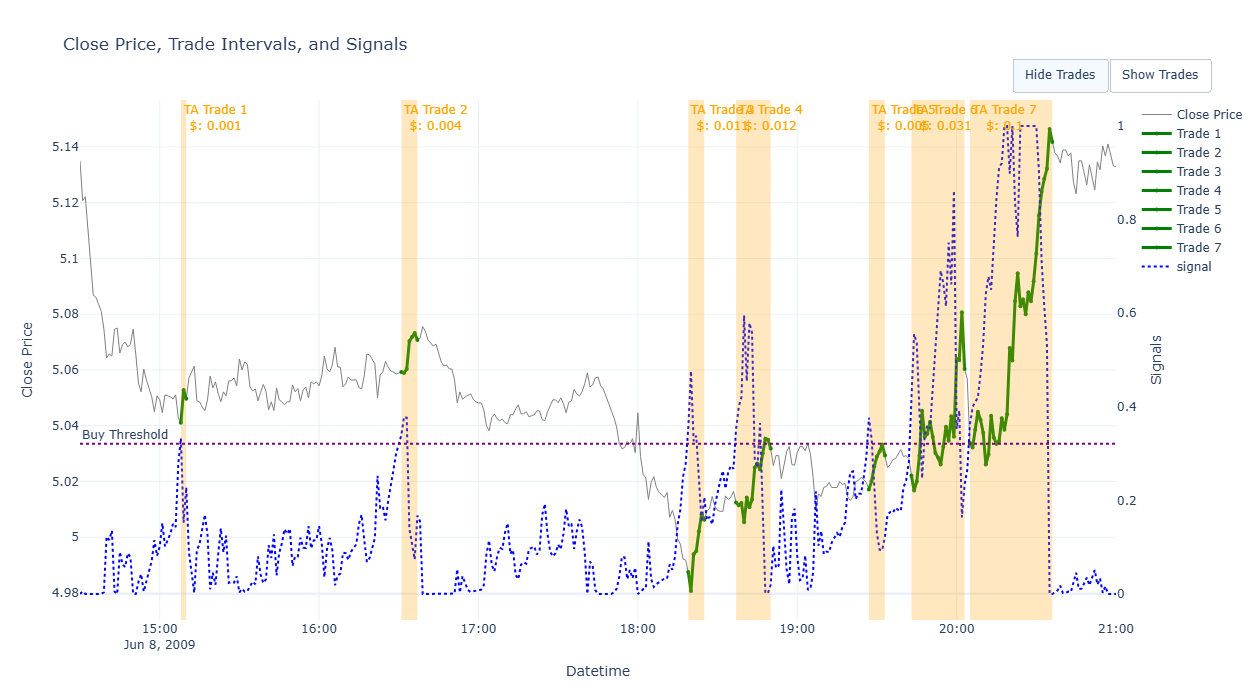


* Performance for 2009-06-08 *
  Buy & Hold Return ($): -0.01
  Strategy Return ($): 0.163
  Trades Returns ($): [0.001, 0.004, 0.011, 0.012, 0.005, 0.031, 0.1]

=== Processing trading day 2009-06-09 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


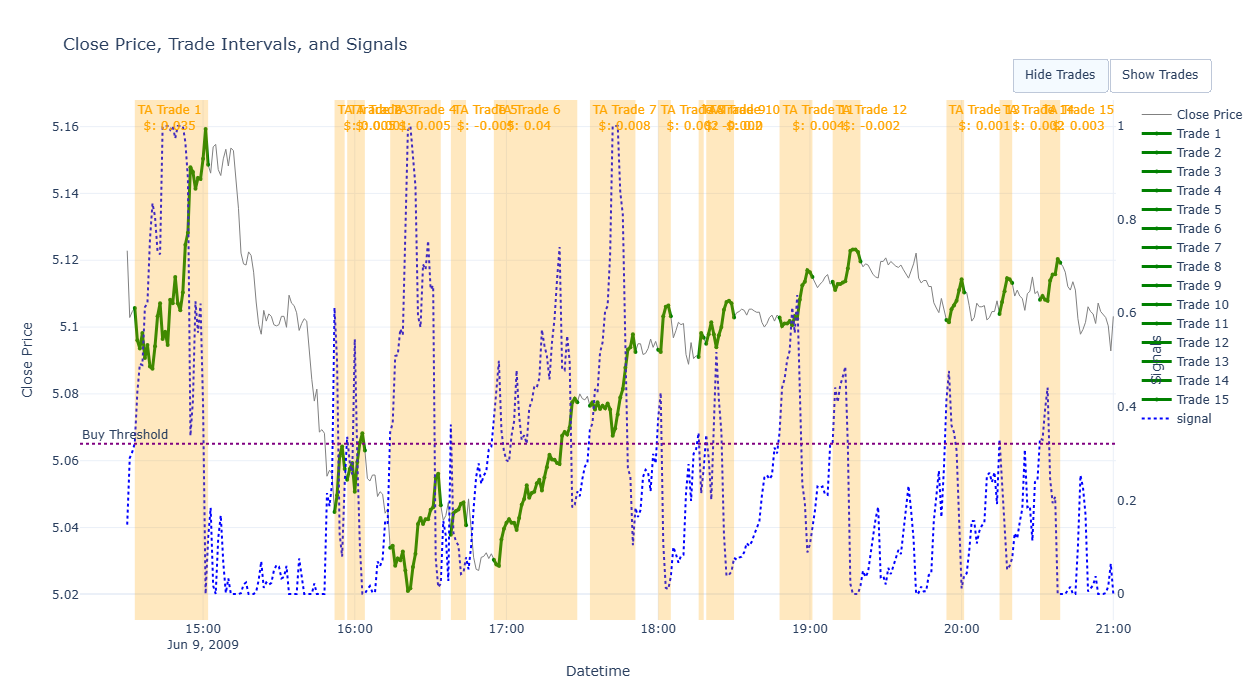


* Performance for 2009-06-09 *
  Buy & Hold Return ($): -0.027
  Strategy Return ($): 0.099
  Trades Returns ($): [0.035, 0.005, 0.001, 0.005, -0.005, 0.04, 0.008, 0.002, -0.002, 0.0, 0.004, -0.002, 0.001, 0.002, 0.003]

=== Processing trading day 2009-06-10 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


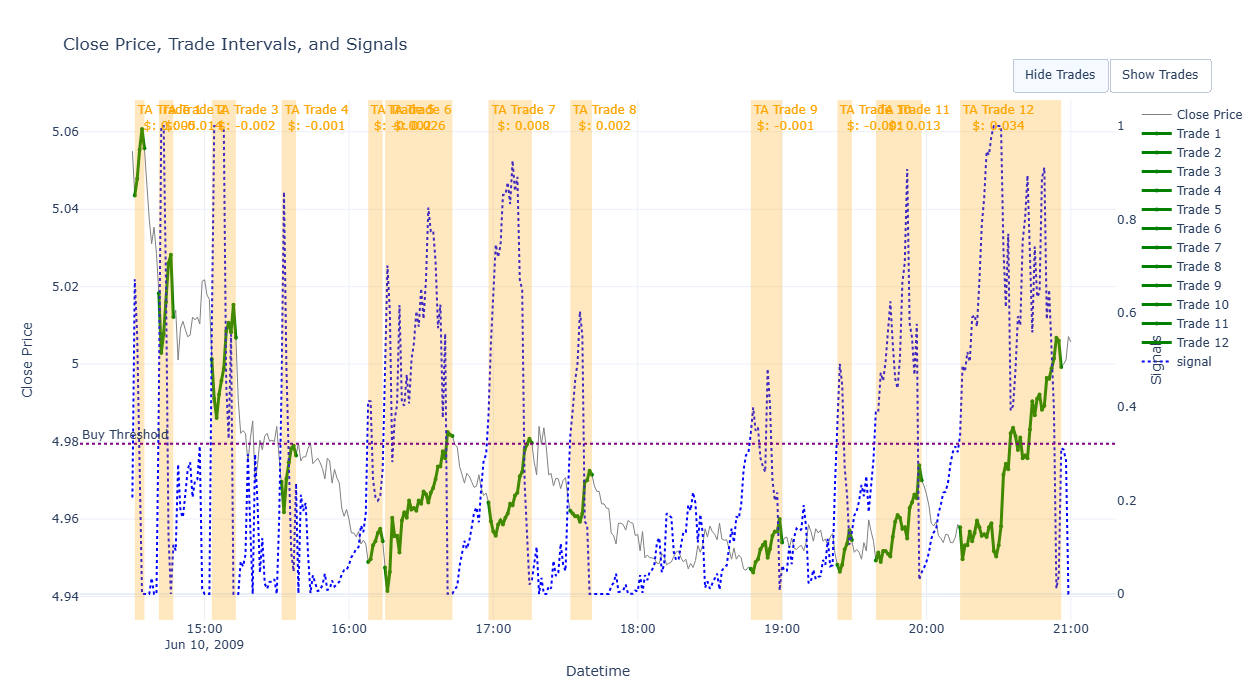


* Performance for 2009-06-10 *
  Buy & Hold Return ($): -0.057
  Strategy Return ($): 0.068
  Trades Returns ($): [0.005, -0.014, -0.002, -0.001, -0.002, 0.026, 0.008, 0.002, -0.001, -0.001, 0.013, 0.034]

=== Processing trading day 2009-06-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


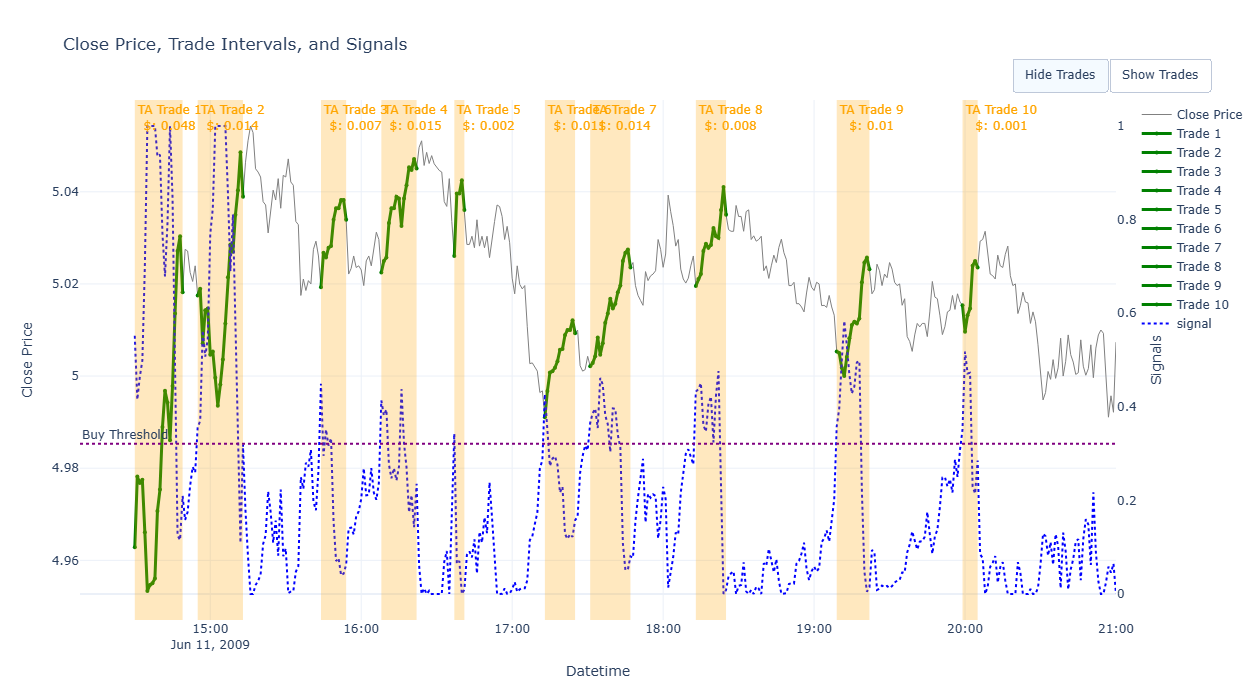


* Performance for 2009-06-11 *
  Buy & Hold Return ($): 0.037
  Strategy Return ($): 0.13
  Trades Returns ($): [0.048, 0.014, 0.007, 0.015, 0.002, 0.011, 0.014, 0.008, 0.01, 0.001]

=== Processing trading day 2009-06-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


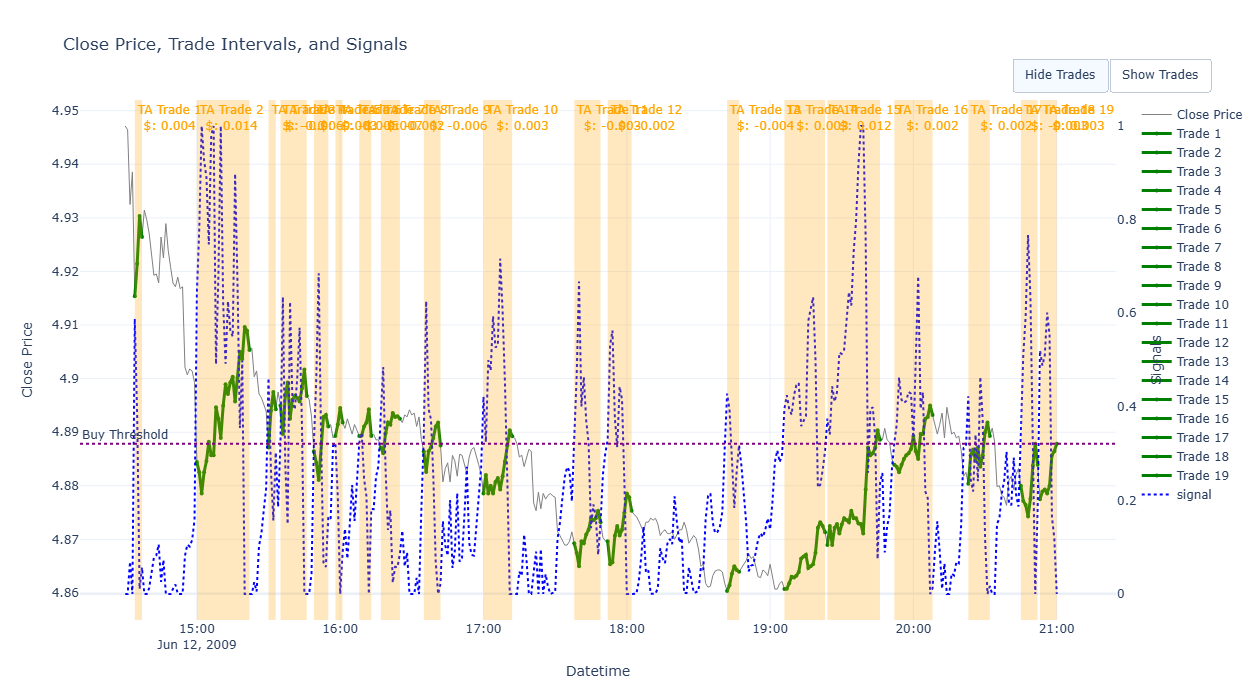


* Performance for 2009-06-12 *
  Buy & Hold Return ($): -0.067
  Strategy Return ($): 0.002
  Trades Returns ($): [0.004, 0.014, -0.0, -0.006, -0.003, -0.005, -0.007, -0.002, -0.006, 0.003, -0.003, -0.002, -0.004, 0.003, 0.012, 0.002, 0.002, -0.003, 0.003]

=== Processing trading day 2009-06-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


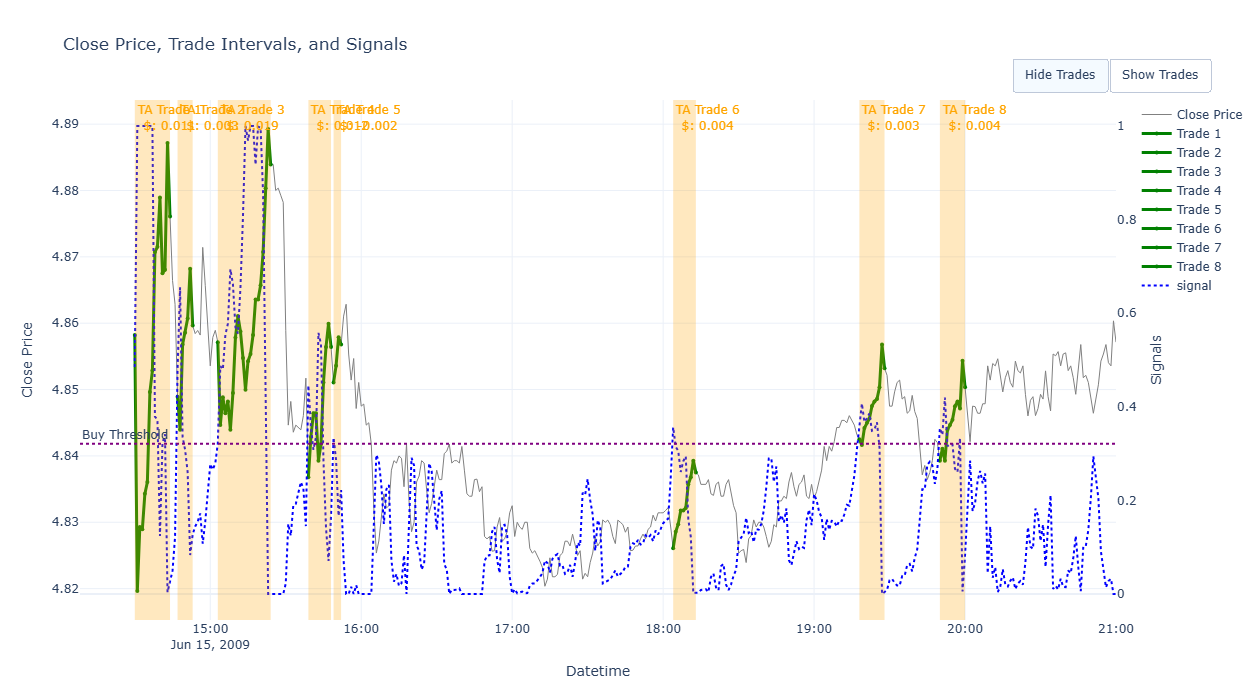


* Performance for 2009-06-15 *
  Buy & Hold Return ($): -0.008
  Strategy Return ($): 0.056
  Trades Returns ($): [0.011, 0.003, 0.019, 0.012, -0.002, 0.004, 0.003, 0.004]

=== Processing trading day 2009-06-16 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


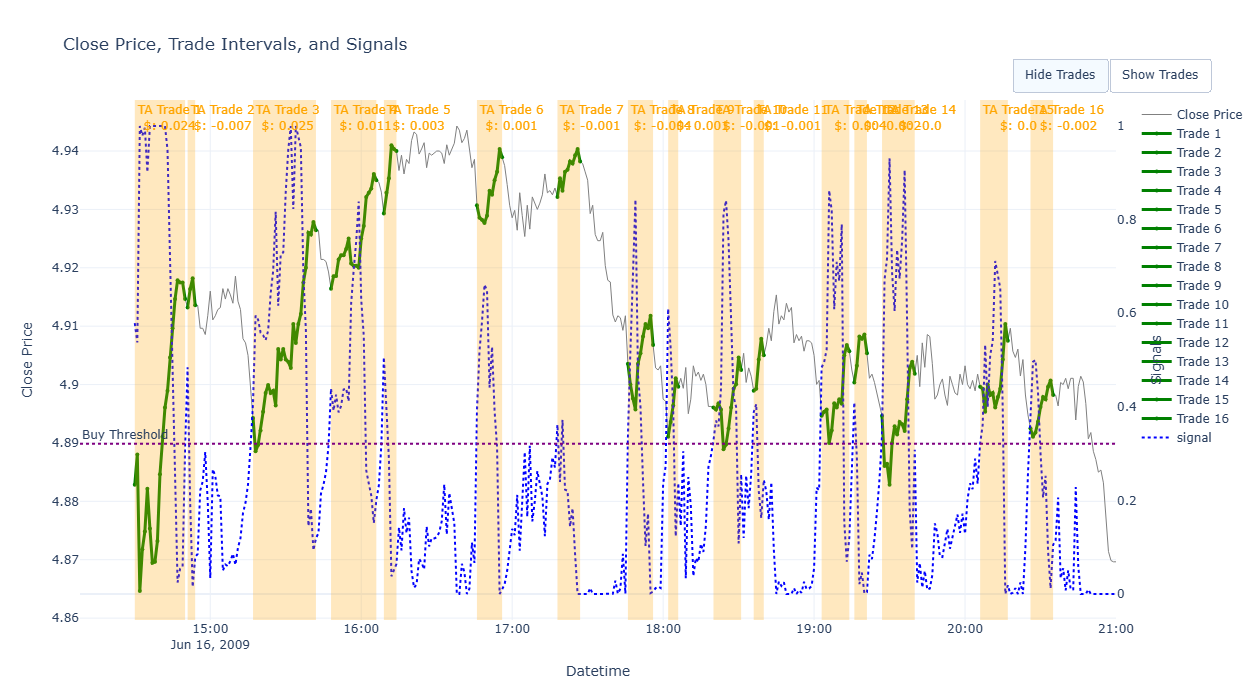


* Performance for 2009-06-16 *
  Buy & Hold Return ($): -0.021
  Strategy Return ($): 0.051
  Trades Returns ($): [0.024, -0.007, 0.025, 0.011, 0.003, 0.001, -0.001, -0.004, 0.001, -0.001, -0.001, 0.004, -0.002, -0.0, 0.0, -0.002]

=== Processing trading day 2009-06-17 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


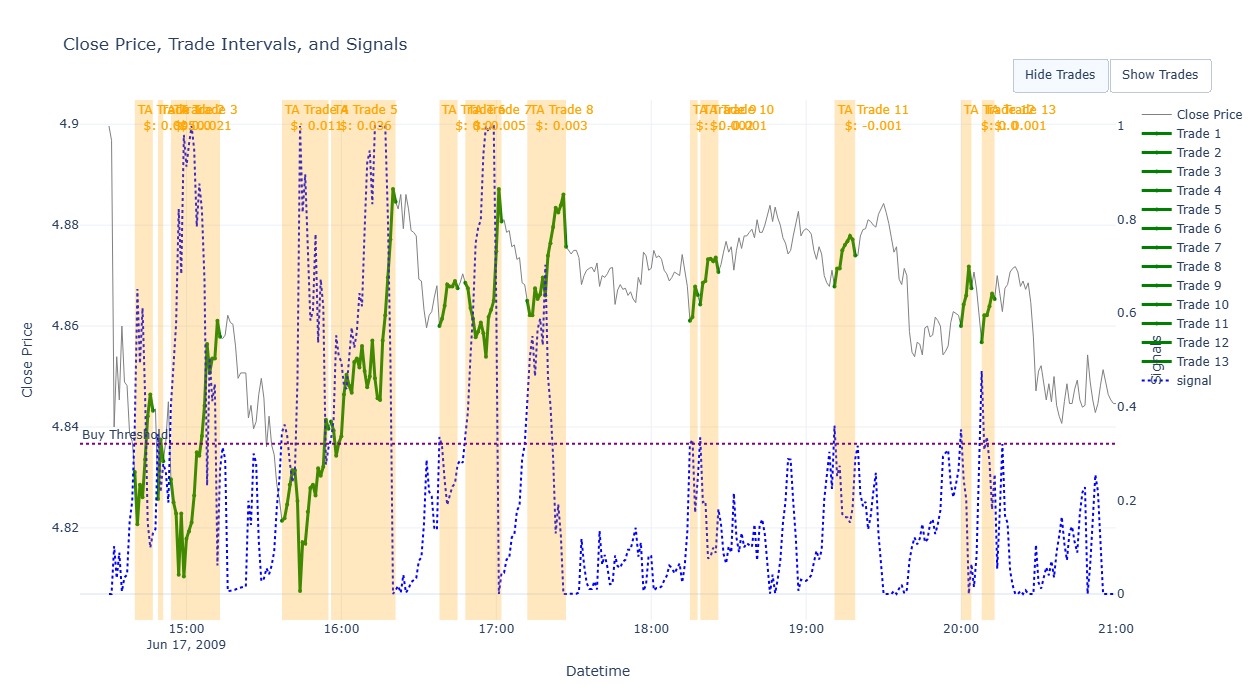


* Performance for 2009-06-17 *
  Buy & Hold Return ($): -0.062
  Strategy Return ($): 0.079
  Trades Returns ($): [0.005, 0.0, 0.021, 0.011, 0.036, 0.0, 0.005, 0.003, -0.002, -0.001, -0.001, 0.0, 0.001]

=== Processing trading day 2009-06-18 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


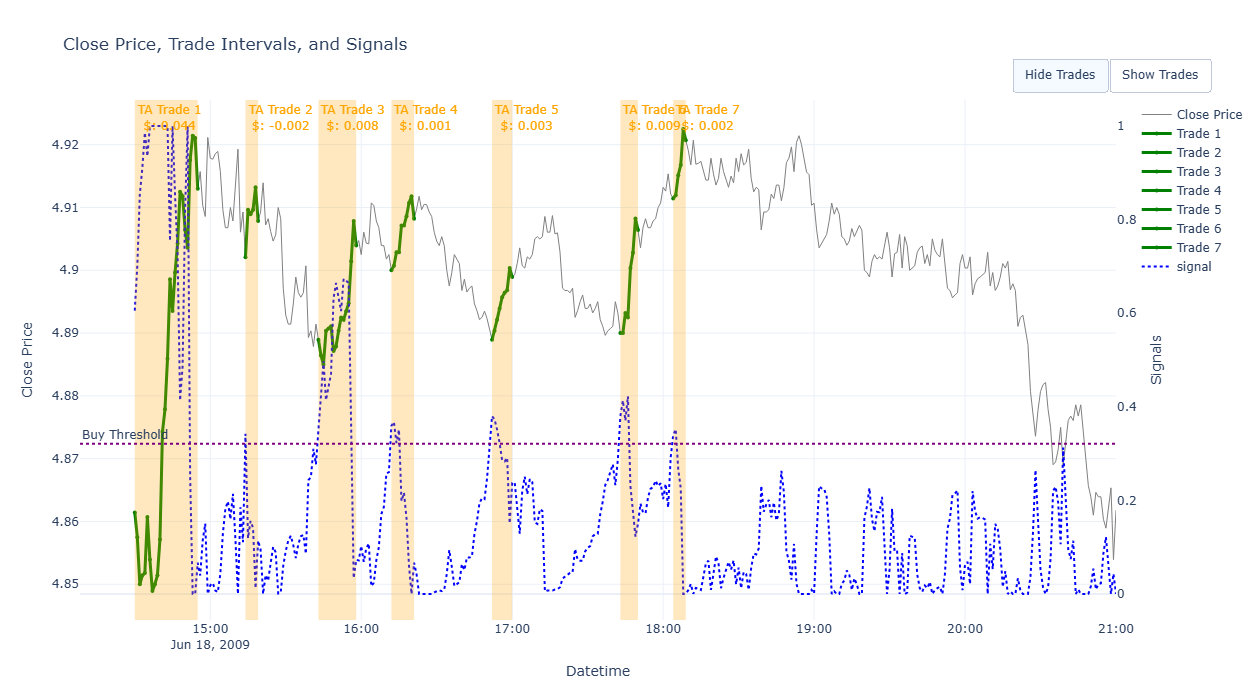


* Performance for 2009-06-18 *
  Buy & Hold Return ($): -0.007
  Strategy Return ($): 0.065
  Trades Returns ($): [0.044, -0.002, 0.008, 0.001, 0.003, 0.009, 0.002]

=== Processing trading day 2009-06-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


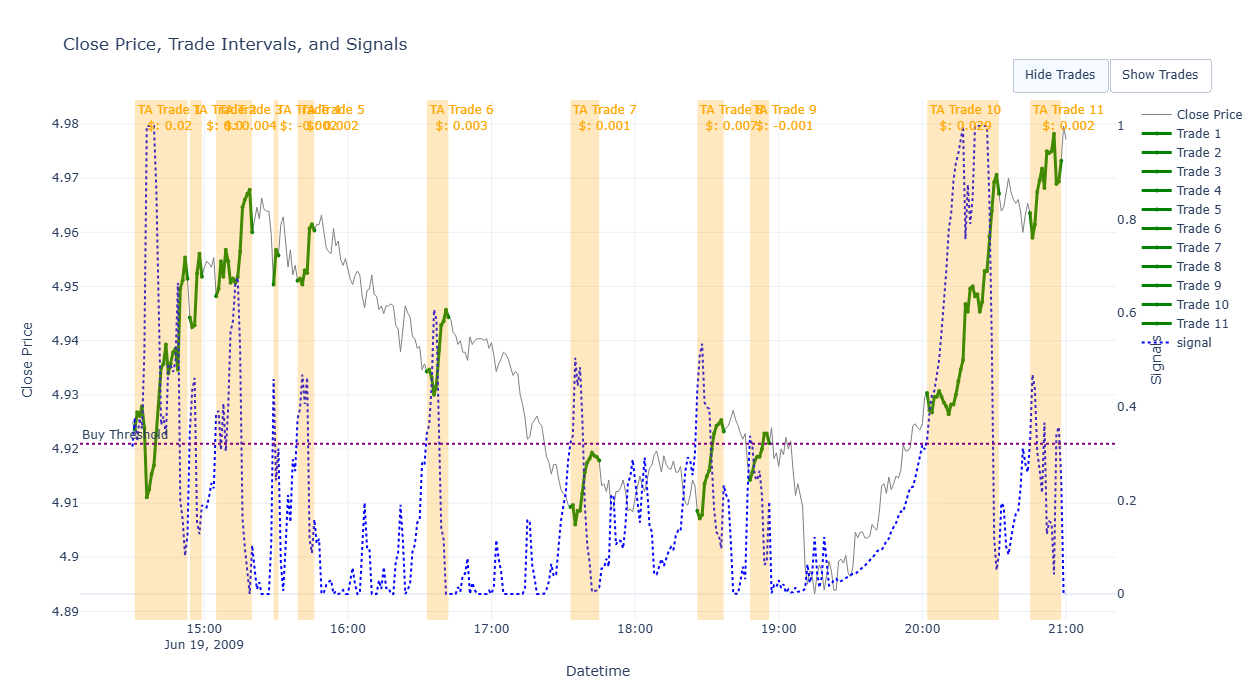


* Performance for 2009-06-19 *
  Buy & Hold Return ($): 0.045
  Strategy Return ($): 0.067
  Trades Returns ($): [0.02, 0.0, 0.004, -0.002, 0.002, 0.003, 0.001, 0.007, -0.001, 0.029, 0.002]

=== Processing trading day 2009-06-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


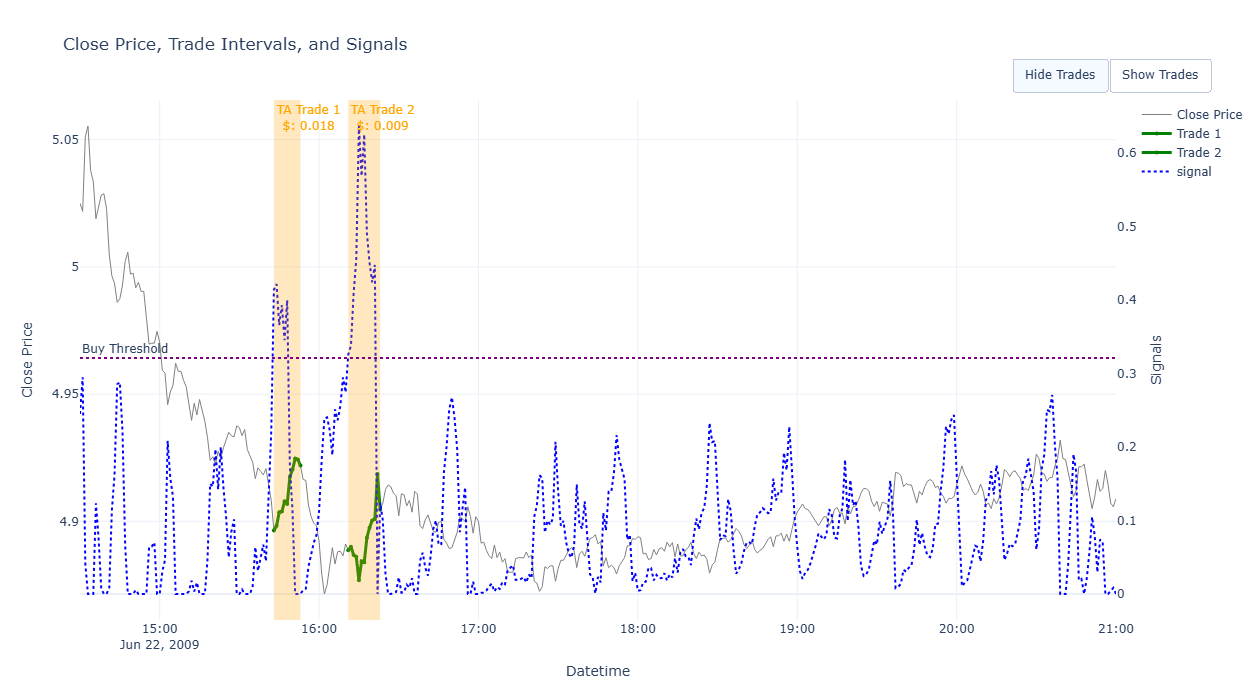


* Performance for 2009-06-22 *
  Buy & Hold Return ($): -0.124
  Strategy Return ($): 0.027
  Trades Returns ($): [0.018, 0.009]

=== Processing trading day 2009-06-23 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


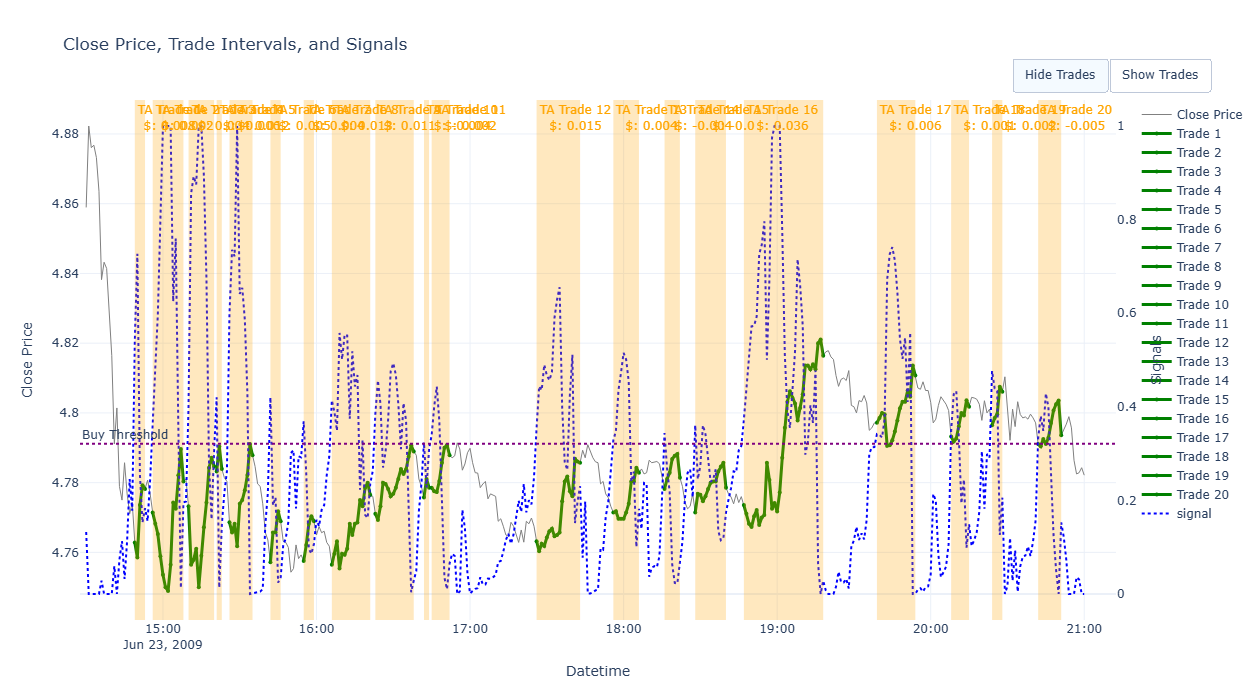


* Performance for 2009-06-23 *
  Buy & Hold Return ($): -0.084
  Strategy Return ($): 0.107
  Trades Returns ($): [0.008, 0.002, 0.004, -0.006, 0.012, 0.005, 0.004, 0.013, 0.011, -0.004, 0.002, 0.015, 0.004, -0.004, -0.0, 0.036, 0.006, 0.001, 0.002, -0.005]

=== Processing trading day 2009-06-24 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


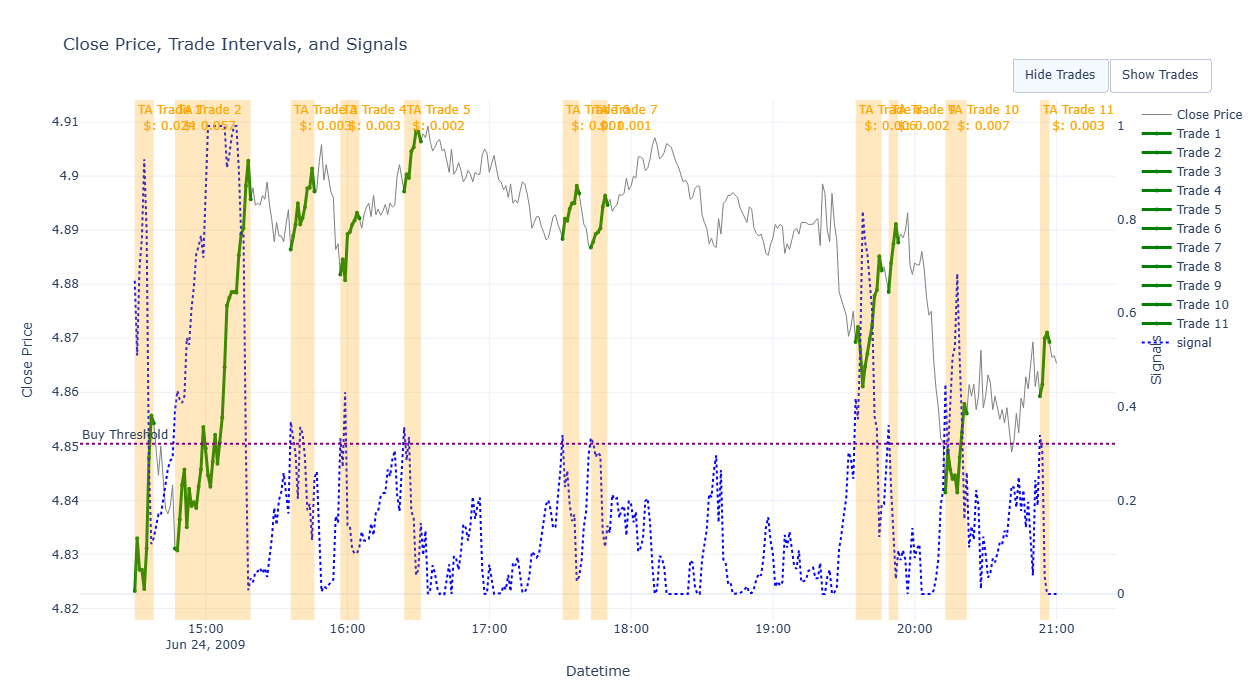


* Performance for 2009-06-24 *
  Buy & Hold Return ($): 0.035
  Strategy Return ($): 0.109
  Trades Returns ($): [0.024, 0.057, 0.003, 0.003, 0.002, 0.001, 0.001, 0.006, 0.002, 0.007, 0.003]

=== Processing trading day 2009-06-25 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


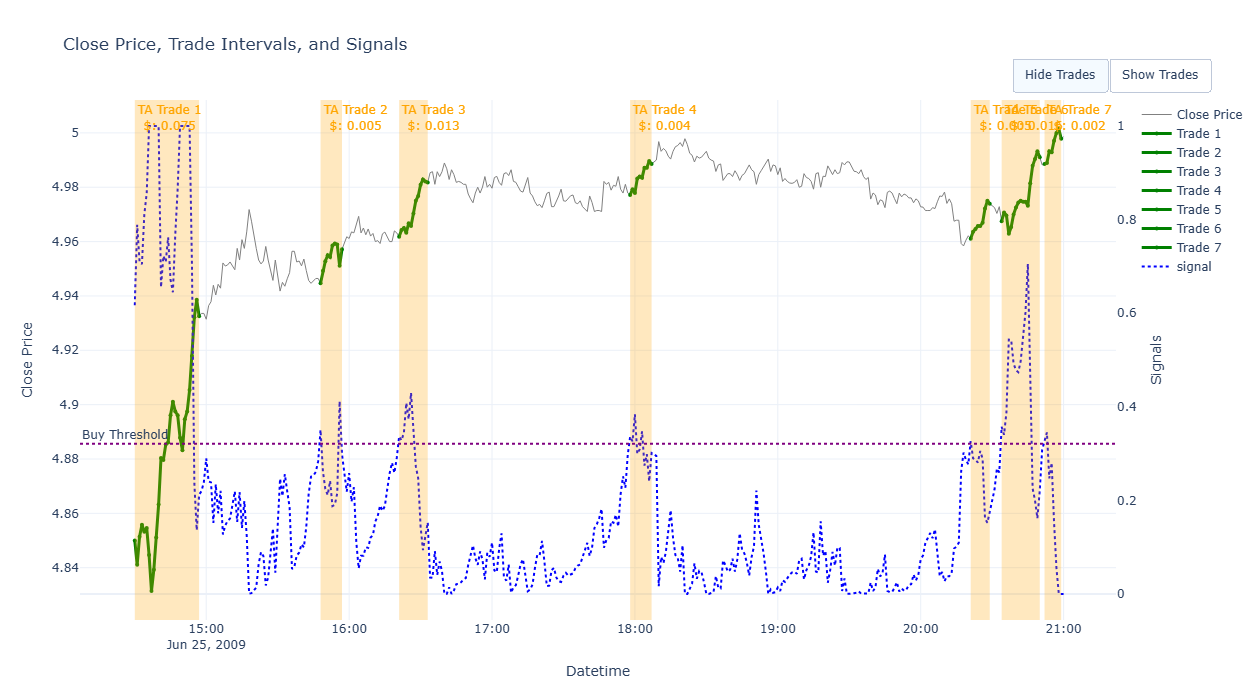


* Performance for 2009-06-25 *
  Buy & Hold Return ($): 0.141
  Strategy Return ($): 0.12
  Trades Returns ($): [0.075, 0.005, 0.013, 0.004, 0.005, 0.016, 0.002]

=== Processing trading day 2009-06-26 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


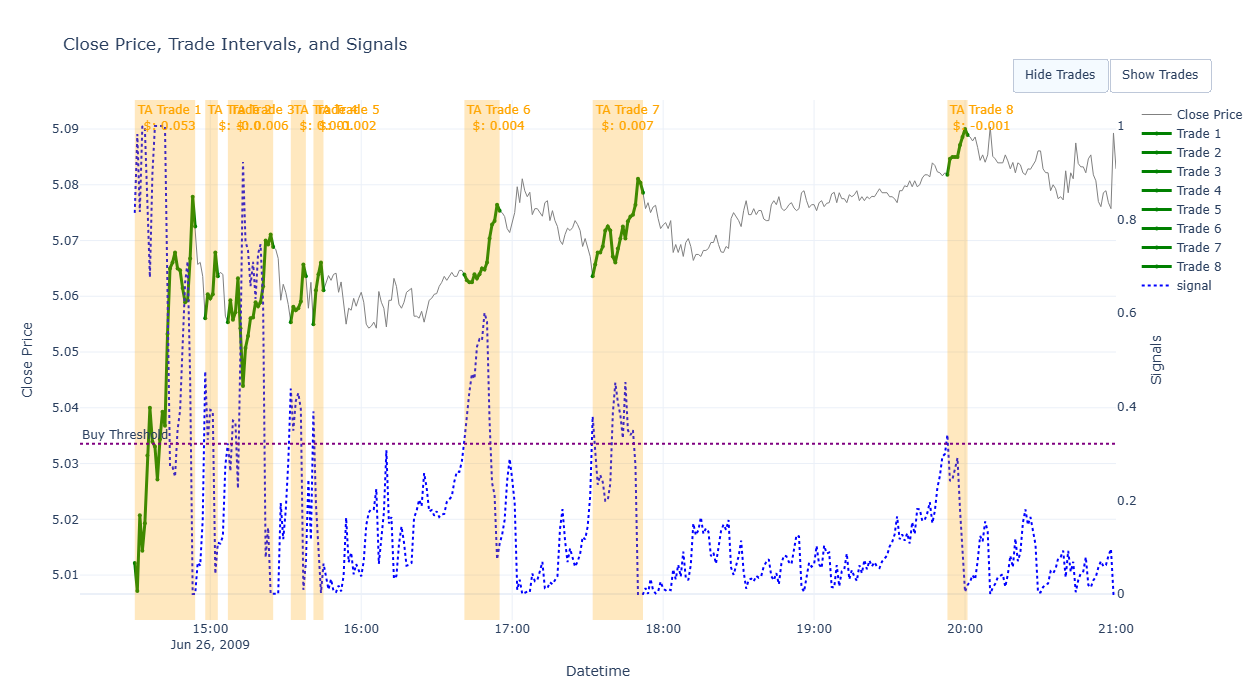


* Performance for 2009-06-26 *
  Buy & Hold Return ($): 0.063
  Strategy Return ($): 0.068
  Trades Returns ($): [0.053, -0.0, 0.006, 0.001, -0.002, 0.004, 0.007, -0.001]

=== Processing trading day 2009-06-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


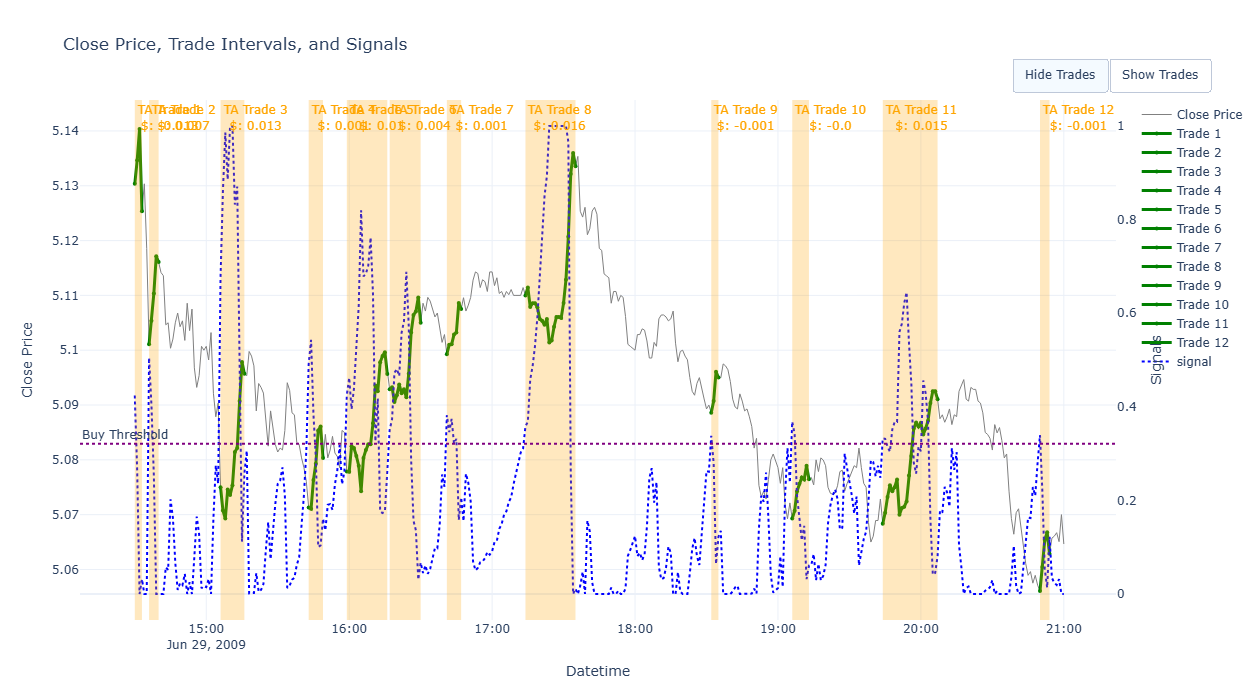


* Performance for 2009-06-29 *
  Buy & Hold Return ($): -0.073
  Strategy Return ($): 0.053
  Trades Returns ($): [-0.013, 0.007, 0.013, 0.001, 0.01, 0.004, 0.001, 0.016, -0.001, -0.0, 0.015, -0.001]

=== Processing trading day 2009-06-30 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


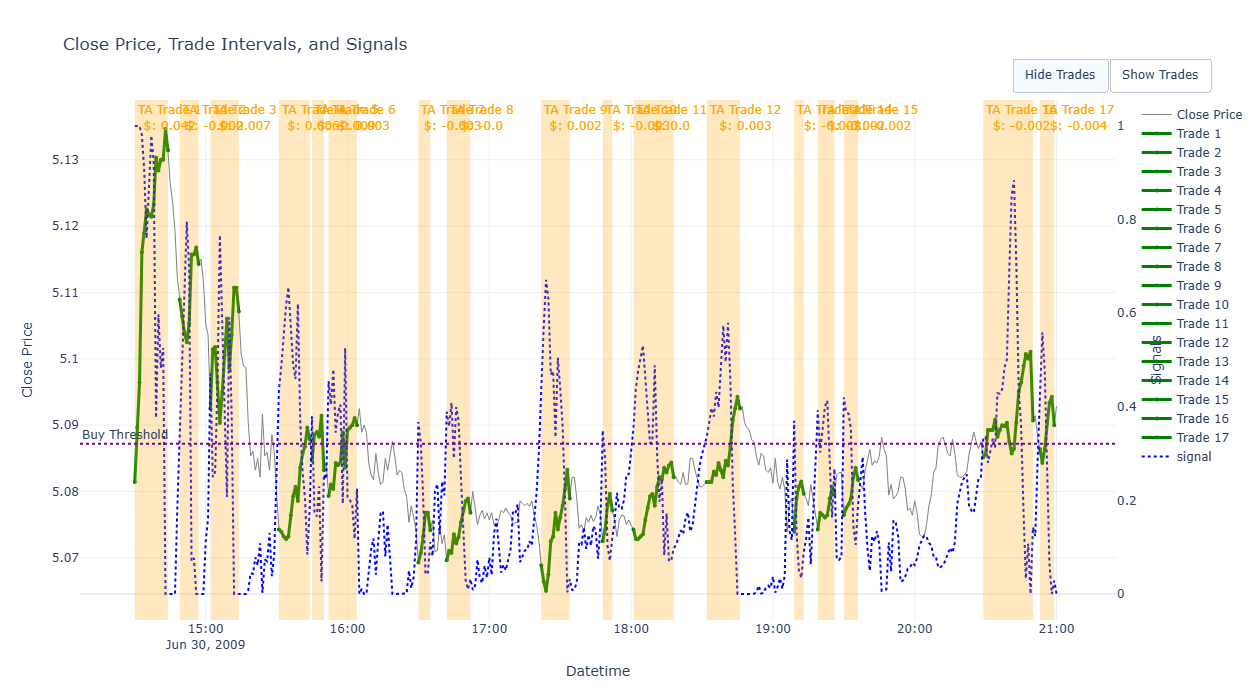


* Performance for 2009-06-30 *
  Buy & Hold Return ($): 0.004
  Strategy Return ($): 0.034
  Trades Returns ($): [0.042, -0.002, 0.007, 0.006, -0.009, 0.003, -0.003, -0.0, 0.002, -0.003, 0.0, 0.003, -0.002, -0.002, -0.002, -0.002, -0.004]

Overall Summary (2009-06-01 = 4.8712 → 2009-06-30 = 5.0890)

One-time buy&hold gain: 0.218
Buy & Hold – each day ($): -0.001
Strategy Return ($): 1.789
Trades Count: 254
Strategy return per trade: 0.007
Num. trading days: 22
Strategy return per trading day: 0.081


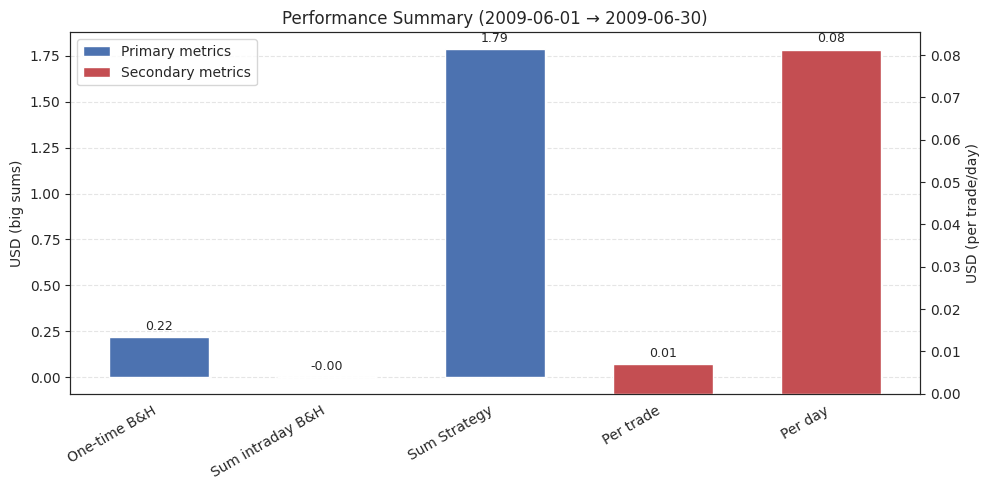

open      high       low     close     volume  \
2009-06-01 09:00:00  4.845714  4.845714  4.845714  4.845714     4200.0   
2009-06-01 09:01:00  4.845714  4.845714  4.845714  4.845714     4200.0   
2009-06-01 09:02:00  4.845714  4.845714  4.845714  4.845714     4200.0   
2009-06-01 09:03:00  4.845714  4.845714  4.845714  4.845714     4200.0   
2009-06-01 09:04:00  4.845714  4.845714  4.845714  4.845714     4200.0   
...                       ...       ...       ...       ...        ...   
2009-06-30 20:56:00  5.086429  5.090357  5.085357  5.090357  1462272.0   
2009-06-30 20:57:00  5.090357  5.093929  5.085714  5.093393  2304568.0   
2009-06-30 20:58:00  5.092857  5.095357  5.092500  5.094286  2122148.0   
2009-06-30 20:59:00  5.094643  5.103214  5.071429  5.090000  8105944.0   
2009-06-30 21:00:00  5.088214  5.096786  5.086786  5.092857  1017884.0   

                          ask       bid        signal  signal_action  \
2009-06-01 09:00:00  4.849350  4.842079  8.366828e-08              0   
2009-06-01 09:01:00  4.849350  4.842079  9.106161e-08              0   
2009-06-01 09:02:00  4.849350  4.842079  9.910824e-08              0   
2009-06-01 09:03:00  4.849350  4.842079  1.078659e-07              0   
2009-06-01 09:04:00  4.849350  4.842079  1.173975e-07              0   
...                       ...       ...           ...            ...   
2009-06-30 20:56:00  5.094175  5.086539  2.602816e-01              0   
2009-06-30 20:57:00  5.097214  5.089571  6.438213e-02              0   
2009-06-30 20:58:00  5.098107  5.090464  0.000000e+00              0   
2009-06-30 20:59:00  5.093818  5.086182  2.819623e-02             -1   
2009-06-30 21:00:00  5.096679  5.089036  0.000000e+00              0   

                     Position   Cash  NetValue    Action  TradedAmount  \
2009-06-01 09:00:00         0  0.000     0.000  No trade             0   
2009-06-01 09:01:00         0  0.000     0.000  No trade             0   
2009-06-01 09:02:00         0  0.000     0.000  No trade             0   
2009-06-01 09:03:00         0  0.000     0.000  No trade             0   
2009-06-01 09:04:00         0  0.000     0.000  No trade             0   
...                       ...    ...       ...       ...           ...   
2009-06-30 20:56:00         1 -5.052     0.035      Hold             0   
2009-06-30 20:57:00         1 -5.052     0.038      Hold             0   
2009-06-30 20:58:00         1 -5.052     0.039      Hold             0   
2009-06-30 20:59:00         0  0.034     0.034      Sell            -1   
2009-06-30 21:00:00         0  0.034     0.034  No trade             0   

                     BuyHoldEarning  StrategyEarning  EarningDiff  
2009-06-01 09:00:00           0.000            0.000        0.000  
2009-06-01 09:01:00           0.000            0.000        0.000  
2009-06-01 09:02:00           0.000            0.000        0.000  
2009-06-01 09:03:00           0.000            0.000        0.000  
2009-06-01 09:04:00           0.000            0.000        0.000  
...                             ...              ...          ...  
2009-06-30 20:56:00           0.001            0.035        0.034  
2009-06-30 20:57:00           0.004            0.038        0.034  
2009-06-30 20:58:00           0.005            0.039        0.034  
2009-06-30 20:59:00           0.001            0.034        0.033  
2009-06-30 21:00:00           0.004            0.034        0.030  

[15862 rows x 17 columns]

In [7]:
print('best_optuna_value:', params.best_optuna_value)
print('best_optuna_params:', params.best_optuna_params)

df_fin = saveDF_checkDAY(
                        df=df,
                        best_optuna_params=params.best_optuna_params
                        )

df_fin

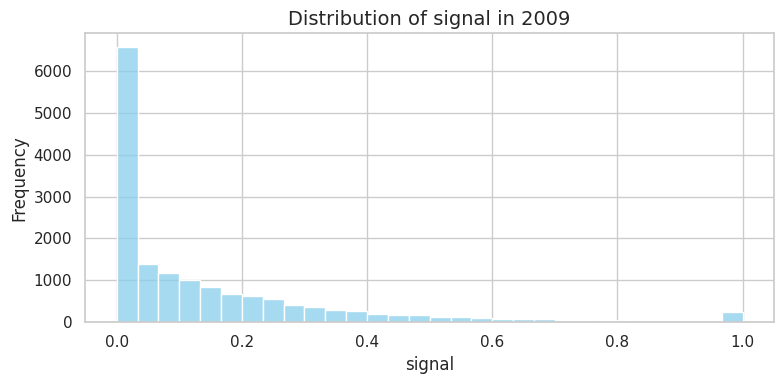

signal_min  signal_max  signal_mean  signal_median  close_return
2009-06         0.0         1.0     0.149062       0.066296      0.113334

In [8]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
